## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Manuel Arambula Gonzalez

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---



## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [42]:
!pip install nlp

In [43]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [44]:
!pip install datasets
import datasets

dataset = datasets.load_dataset('emotion')

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [46]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [47]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [48]:
tweets, labels = get_tweets(train)

In [49]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 3: Tokenizer

1. Tokenizing the tweets

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [51]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

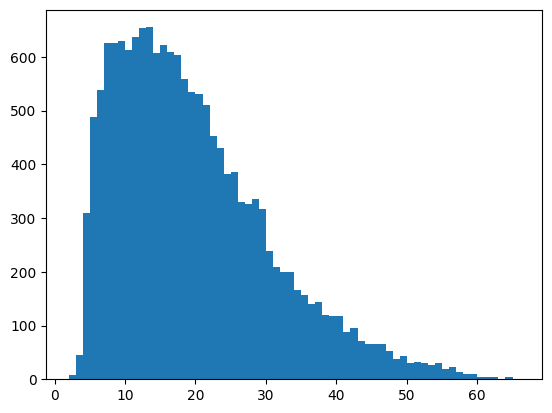

In [52]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [54]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [55]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [56]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [57]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


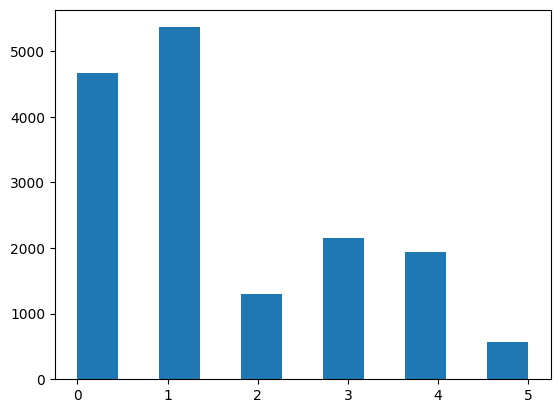

In [58]:
plt.hist(labels, bins=11)
plt.show()

In [59]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [60]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [61]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [62]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [63]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 6: Creating the Model

1. Creating the model
2. Compiling the model

In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 7: Training the Model

1. Preparing a validation set
2. Training the model

In [65]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [66]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [67]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3816 - loss: 1.5363 - val_accuracy: 0.6025 - val_loss: 1.0303
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6751 - loss: 0.8469 - val_accuracy: 0.7865 - val_loss: 0.6443
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8559 - loss: 0.4371 - val_accuracy: 0.8345 - val_loss: 0.5330
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9131 - loss: 0.2742 - val_accuracy: 0.8415 - val_loss: 0.4828
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9287 - loss: 0.2080 - val_accuracy: 0.8605 - val_loss: 0.4341
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9473 - loss: 0.1628 - val_accuracy: 0.8765 - val_loss: 0.4125
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9624 - loss: 0.1180 - val_accuracy: 0.8800 - val_loss: 0.3973
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9712 - loss: 0.1018 - val_

## Task 8: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

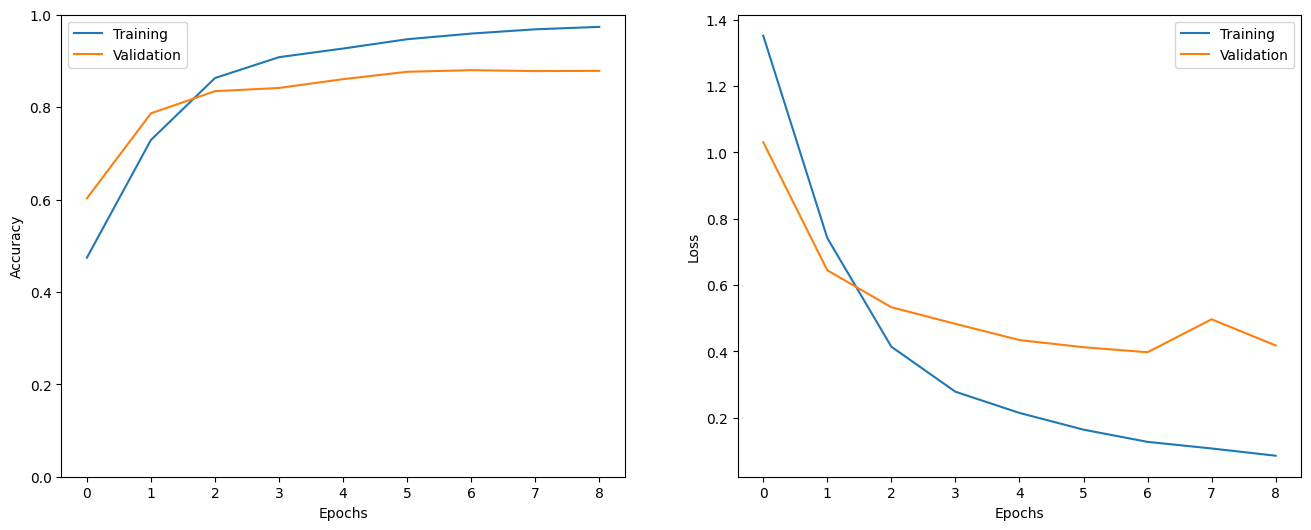

In [68]:
show_history(h)

In [69]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [70]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8720 - loss: 0.4290


In [71]:
classes_to_index = {'anger': 0, 'joy': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'sadness': 5}
index_to_classes = {0: 'anger', 1: 'joy', 2: 'love', 3: 'surprise', 4: 'fear', 5: 'sadness'}

In [77]:
predicted_emotion = index_to_classes.get(p)


In [106]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

# Use predict and argmax to get predicted class
predictions = model.predict(np.expand_dims(test_sequences[i], axis=0))
p = np.argmax(predictions)

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i feel extremely honoured to have received such a prestigious award
Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Emotion: joy


In [74]:
# Use predict to get the predicted probabilities for each class
preds = model.predict(test_sequences)
# Get the class with the highest probability
preds = np.argmax(preds, axis=1)

preds.shape, test_labels.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


((2000,), (2000,))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


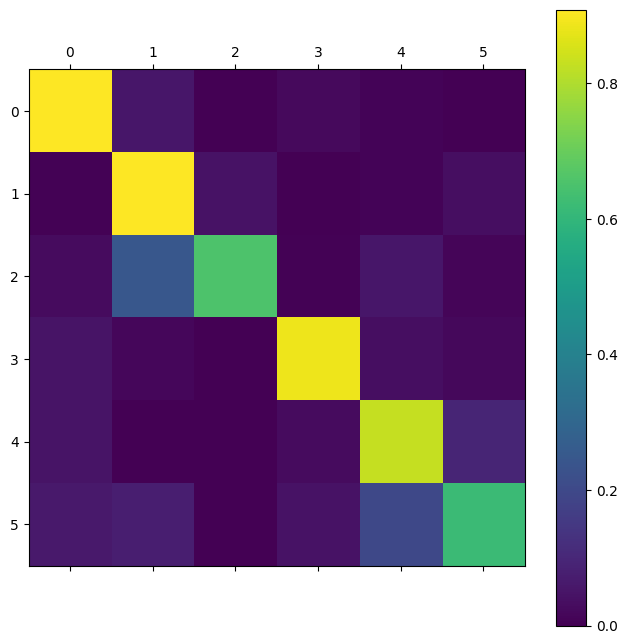

In [75]:
# Use predict to get the predicted probabilities for each class
preds = model.predict(test_sequences)
# Get the class with the highest probability
preds = np.argmax(preds, axis=1)

preds.shape, test_labels.shape

show_confusion_matrix(test_labels, preds, list(classes))

'anger': 0, 'joy': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'sadness': 5